**PREPARATION**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm
import sys

import ddpm
import datasets

import os
import trimesh

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

print(f"PyTorch version Installed: {torch.__version__}\nTorchvision version Installed: {torchvision.__version__}\n")
if not torch.__version__.startswith("1.11"):
    print("you are using an another version of PyTorch. We expect PyTorch 1.11.0. You may continue using your version but it"
          " might cause dependency and compatibility issues.")
if not torchvision.__version__.startswith("0.12"):
    print("you are using an another version of torchvision. We expect torchvision 0.12. You can continue with your version but it"
          " might cause dependency and compatibility issues.")

PyTorch version Installed: 2.0.1+cu117
Torchvision version Installed: 0.15.2+cu117

you are using an another version of PyTorch. We expect PyTorch 1.11.0. You may continue using your version but it might cause dependency and compatibility issues.
you are using an another version of torchvision. We expect torchvision 0.12. You can continue with your version but it might cause dependency and compatibility issues.


**DATASET & DATALOADER**

In [4]:
# DATA NORMALIZATION FUNCTION PRIOR TO DATASET GENERATION

# Import dataset class
from grasp_object_dataset import graspDataset
from torch.utils.data import DataLoader

# Function to obtain mean, std, max, and min of given dataset
def get_mean_std(main_dir, object_dir, dataset):

    # Allocate variables
    full_joints = []

    # Load all samples - only joint values!
    for sample in tqdm(dataset):
        joints = sample[0]
        full_joints.append(joints)

    mean = np.mean(full_joints, axis = 0)
    std = np.std(full_joints, axis = 0)
    max = np.max(full_joints, axis = 0)
    min = np.min(full_joints, axis = 0)
    

    return mean, std, max, min


In [5]:
# DATASET AND DATALOADER DEFINITION

# Import dataset class
from grasp_object_dataset import graspDataset
from torch.utils.data import DataLoader

# Directories of dataset grasps + objects: set to a small version of it to overfit!! Full version found in dataset_XX_full
main_dir = './dataset_grasps_full/'
object_dir = './dataset_objects_full/'

# Generate dataset with all dataset samples
main_dataset = graspDataset(main_dir, object_dir, mode = 'train', split = {'train': 1, 'val': 0, 'test': 0}, normalization=None, transform_joint = None, transform_object = None)

# Calculate mean, std, max, min of full dataset
mean_std_max_min = list(get_mean_std(main_dir, object_dir, main_dataset))
# Print not norm data
print('NOT NORMALIZED: ', mean_std_max_min)

# Datasets definition
train_dataset = graspDataset(main_dir, object_dir, mode = 'train', split = {'train': 1, 'val': 0, 'test': 0}, normalization=mean_std_max_min)#, transform_joint = None, transform_object = None)
#val_dataset = graspDataset(main_dir, object_dir, mode = 'val', split = {'train': 1, 'val': 0, 'test': 0}, normalization=mean_std_max_min)#, transform_joint = None, transform_object = None)
#test_dataset = graspDataset(main_dir, object_dir, mode = 'test', split = {'train': 1, 'val': 0, 'test': 0}, normalization=mean_std_max_min)#, transform_joint = None, transform_object = None)

# Comparison for normalized dataset
mean_std_max_min_2 = list(get_mean_std(main_dir, object_dir, train_dataset))
print('NORMALIZED: ', mean_std_max_min_2)

# Dataloader definition
train_dataloader = DataLoader(train_dataset , batch_size=64, shuffle=True, num_workers=2, drop_last=False)
#val_dataloader = DataLoader(val_dataset , batch_size=64, shuffle=True, num_workers=2, drop_last=False)
#test_dataloader = DataLoader(test_dataset , batch_size=64, shuffle=True, num_workers=2, drop_last=False)

  0%|          | 0/21000 [00:00<?, ?it/s]

NOT NORMALIZED:  [array([ 3.98561844e-02,  2.57192661e-01,  5.95373810e-01,  1.67236000e-01,
        2.65023496e-02,  2.65105132e-01,  6.80795671e-01,  1.57267439e-01,
        1.17773209e-02,  3.03083575e-01,  6.61583456e-01,  1.70557048e-01,
        2.61156612e-01, -1.07516990e-01,  2.03640379e-01,  5.48817102e-01,
        2.04976352e-01,  2.73408066e-01,  1.04242190e+00, -1.19935514e-02,
       -2.36260475e-01, -6.06011368e-02, -6.05525100e-02,  8.50713967e-03,
       -2.46173353e-02,  6.38794029e-05, -3.58334739e-03, -7.04945023e-04]), array([0.08841094, 0.12425186, 0.13485115, 0.17028817, 0.08242855,
       0.10374933, 0.19098119, 0.17153302, 0.09209367, 0.11868084,
       0.17730865, 0.17665884, 0.10540849, 0.08868023, 0.09023743,
       0.23112383, 0.19124254, 0.22412766, 0.11790531, 0.10479109,
       0.20813474, 0.08463916, 1.78267916, 0.65887648, 1.78051084,
       0.09024645, 0.09977398, 0.08307887]), array([0.44093332, 0.72629118, 1.05269575, 0.85050714, 0.34213725,
       0

  0%|          | 0/21000 [00:00<?, ?it/s]

NORMALIZED:  [array([-0.12520227, -0.05825086, -0.03482967, -0.56303924, -0.00694221,
       -0.09080227,  0.1099189 , -0.58760699, -0.0257935 , -0.01083718,
       -0.02048508, -0.49064162,  0.0814    , -0.11457864, -0.10987953,
       -0.16722104, -0.49478828, -0.01662538,  0.27163743, -0.02297611,
       -0.02433884,  0.43323216, -0.01928046,  0.00724428, -0.00791501,
        0.00340821, -0.00509778, -0.00069022]), array([0.24803257, 0.28030283, 0.30514164, 0.38954828, 0.26296456,
       0.29795695, 0.32953832, 0.40987787, 0.24830535, 0.30361581,
       0.30488528, 0.36616864, 0.24984337, 0.2441268 , 0.27511499,
       0.33594732, 0.40974628, 0.38852221, 0.25021091, 0.36027187,
       0.37334508, 0.27221381, 0.5674609 , 0.42084961, 0.56687281,
       0.36866746, 0.40530449, 0.34397149]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.

In [6]:
# DATASET INDICES

# train_dataset[sample][index]
# index = 0 --> joint angles
# index = 1 --> label (grasp type) - one hot vector
# index = 2 --> matrix distances
# index = 3 --> file name

print(train_dataset[2002][1])
print(train_dataset[1000][1])
print(len(train_dataset))

[0. 0. 1.]
[0. 0. 1.]
21000


**DIFFUSION MODEL**

In [21]:
# HYPERPARAMETERS FOR TUNING

# model
hidden_size = 128
hidden_layers = 3
emb_size= 64
time_emb= "sinusoidal"
input_emb= "sinusoidal"

# Noise scheduler
num_timesteps = 50
beta_schedule= 'linear'

# optimizer
learning_rate = 1e-4

#training
num_epochs = 50


In [22]:
model = ddpm.MLP(
        hidden_size= hidden_size,
        hidden_layers=hidden_layers,
        emb_size= emb_size,
        time_emb= time_emb,
        input_emb= input_emb
        )

model.cuda()

noise_scheduler = ddpm.NoiseScheduler(
        num_timesteps=num_timesteps,
        beta_schedule=beta_schedule)

avg_loss = []


In [23]:
optimizer = torch.optim.AdamW(
        model.parameters(),
        lr= learning_rate,
    )

In [24]:
global_step = 0
frames = []
losses = []
print("Training model...")
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in enumerate(train_dataloader):
        # Variables
        joint_angles_batch = batch[0]
        label_one_hot = batch[1]
        mat_distances = batch[2]

        # Noise and timesteps
        noise = torch.randn(joint_angles_batch.shape)
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (joint_angles_batch.shape[0],)).long()

        noisy = noise_scheduler.add_noise(joint_angles_batch, noise, timesteps)
        noisy = noisy.double().cuda()

        joint_angles_batch = joint_angles_batch.cuda()
        label_one_hot = label_one_hot.cuda() 
        mat_distances = mat_distances.cuda()
        timesteps = timesteps.cuda() 

        noise_pred = model(noisy, timesteps, label_one_hot, mat_distances)
        noise = noise.cuda()
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1

    progress_bar.close()

    avg_loss.append(np.mean(losses))
    losses = []


"""
    if epoch % config.save_images_step == 0 or epoch == config.num_epochs - 1:
        # generate data with the model to later visualize the learning process
        model.eval()
        sample = torch.randn(config.eval_batch_size, 2)
        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(tqdm(timesteps)):
            t = torch.from_numpy(np.repeat(t, config.eval_batch_size)).long()
            with torch.no_grad():
                residual = model(sample, t)
            sample = noise_scheduler.step(residual, t[0], sample)
        frames.append(sample.numpy())

print("Saving model...")
outdir = f"exps/{config.experiment_name}"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/model.pth")

print("Saving images...")
imgdir = f"{outdir}/images"
os.makedirs(imgdir, exist_ok=True)
frames = np.stack(frames)
xmin, xmax = -6, 6
ymin, ymax = -6, 6
for i, frame in enumerate(frames):
    plt.figure(figsize=(10, 10))
    plt.scatter(frame[:, 0], frame[:, 1])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.savefig(f"{imgdir}/{i:04}.png")
    plt.close()
    
print("Saving loss as numpy array...")
np.save(f"{outdir}/loss.npy", np.array(losses))
print("Saving frames...")
np.save(f"{outdir}/frames.npy", frames)
"""

Training model...


  0%|          | 0/329 [00:00<?, ?it/s]

/home/jgual/ADLRProject/ddpm.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor= torch.tensor(label, dtype=torch.float32)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

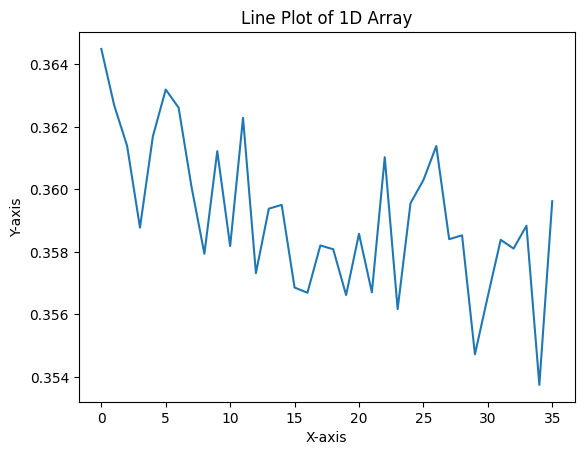

In [87]:
# Plot the 1D array as a line plot
plt.plot(avg_loss)

# Add labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot of 1D Array')

# Show the plot
plt.show()

In [105]:
print("Saving model...")
experiment_name = 'full_normalization'
outdir = f"exps/{experiment_name}"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/model_Full.pth")

Saving model...


**MODEL INFERENCE --> EVALUATION OF RESULTS**

In [70]:
# Load a model

model = ddpm.MLP(
        hidden_size= hidden_size,
        hidden_layers=hidden_layers,
        emb_size= emb_size,
        time_emb= time_emb,
        input_emb= input_emb
        )


model.load_state_dict(torch.load('./model_pruebas.pth'))
model.eval()


RuntimeError: Error(s) in loading state_dict for MLP:
	Missing key(s) in state_dict: "conv_layers.0.weight", "conv_layers.0.bias", "conv_layers.3.weight", "conv_layers.3.bias", "conv_layers.6.weight", "conv_layers.6.bias", "conv_layers.10.weight", "conv_layers.10.bias". 
	size mismatch for joint_mlp.0.weight: copying a param with shape torch.Size([128, 3715]) from checkpoint, the shape in current model is torch.Size([128, 2371]).

In [97]:
# Directory for grasping validation
main_dir = './dataset_grasps/'
object_dir = './dataset_objects/'

# Grasp code for which we have overfitting
grasp_code = 'core-bottle-1ae823260851f7d9ea600d1a6d9f6e07'
grasp_code = 'core-bottle-56c23ba1699f6294435b5a0263ddd2e2'

# Load matrix distance for given object
matriz_distancias = np.load(os.path.join(object_dir+grasp_code+".npy"), allow_pickle=True)*0.11
matriz_distancias = torch.from_numpy(matriz_distancias)
matriz_distancias = matriz_distancias.reshape(1, 50, 50, 50)

# Define matrix for given object
label = torch.tensor([0, 1, 0])
label = label.reshape(1, 3)

In [102]:
# Model inference
model.eval()

eval_batch_size = 1
num_timesteps = 50
plot_step = 5

noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 28)
timesteps = list(range(num_timesteps))[::-1]

samples = []
steps = []

for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t, label, matriz_distancias)
        
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.numpy())
        steps.append(i + 1)

# Generated test grasp is saved in samples[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

In [99]:
reference = train_dataset[1000][0]
print(train_dataset[1000][1])

[0. 0. 1.]


In [103]:
# Print of joint angles for predicted grasp
reference = (reference + 1)/2
reference = reference * (mean_std_max_min[2]- mean_std_max_min[3]) + mean_std_max_min[3]
print(reference)


# Set sample to predicted test sample
sample = samples[-1][0]

# Return normalized values to the initial values
sample = (sample + 1)/2
sample = sample * (mean_std_max_min[2]- mean_std_max_min[3]) + mean_std_max_min[3]

print(sample)


print(reference - sample)

[ 8.43518626e-02  4.45434051e-01  8.36429448e-01  5.19959599e-01
 -3.02945394e-03  3.54335602e-01  1.03701114e+00  4.66638299e-01
 -3.27332825e-02  3.93936735e-01  1.07846985e+00  4.71659378e-01
  2.82837885e-01 -1.48703576e-01  3.48361491e-01  9.82202088e-01
  5.80607123e-01  4.03095060e-01  1.45516237e+00  2.92959418e-02
 -2.18118222e-01 -2.31884712e-01 -3.89419377e+00  2.37436437e-01
  5.11667051e+00  1.84190271e-02 -3.09513992e-03 -2.53094190e-02]
[ 0.19763075  0.14803024  0.68435926  0.32374528  0.16740186  0.34184319
  0.41129443  0.14234021  0.04546428  0.33026552  0.32304566  0.19059451
  0.19779122 -0.10454334  0.05403051  0.18009994  0.34178611  0.43789314
  0.77871698 -0.20834903 -0.51078157 -0.16527118  1.71395561  0.52873441
 -1.49829821  0.11693642 -0.02069149  0.01034403]
[-0.11327889  0.29740381  0.15207019  0.19621432 -0.17043132  0.01249241
  0.62571671  0.32429809 -0.07819756  0.06367121  0.75542419  0.28106486
  0.08504666 -0.04416024  0.29433098  0.80210215  0.2388

**VISUALIZATION OF RESULT**

In [40]:
import random
from utils.hand_model_lite import HandModelMJCFLite
import numpy as np
import transforms3d
import torch
import trimesh

In [65]:
mesh_path = './test_files/meshdata/'
data_path = './test_files/dexgraspnet/'


use_visual_mesh = False

hand_file = "mjcf/shadow_hand_vis.xml" if use_visual_mesh else "mjcf/shadow_hand_wrist_free.xml"

joint_names = [
    'robot0:FFJ3', 'robot0:FFJ2', 'robot0:FFJ1', 'robot0:FFJ0',
    'robot0:MFJ3', 'robot0:MFJ2', 'robot0:MFJ1', 'robot0:MFJ0',
    'robot0:RFJ3', 'robot0:RFJ2', 'robot0:RFJ1', 'robot0:RFJ0',
    'robot0:LFJ4', 'robot0:LFJ3', 'robot0:LFJ2', 'robot0:LFJ1', 'robot0:LFJ0',
    'robot0:THJ4', 'robot0:THJ3', 'robot0:THJ2', 'robot0:THJ1', 'robot0:THJ0'
]
translation_names = ['WRJTx', 'WRJTy', 'WRJTz']
rot_names = ['WRJRx', 'WRJRy', 'WRJRz']

In [42]:
# Load hand file
hand_model = HandModelMJCFLite(
    hand_file,
    "mjcf/meshes")

In [66]:
# Load grasp original code and object
grasp_code = 'core-bottle-1ae823260851f7d9ea600d1a6d9f6e07'
grasp_data = np.load(
    os.path.join(data_path, grasp_code+".npy"), allow_pickle=True)
object_mesh_origin = trimesh.load(os.path.join(
    mesh_path, grasp_code, "coacd/decomposed.obj"))

{'robot0:FFJ3': -0.24548496305942535, 'robot0:FFJ2': 0.6087559461593628, 'robot0:FFJ1': 0.7188290357589722, 'robot0:FFJ0': 0.2019304633140564, 'robot0:MFJ3': -0.17577102780342102, 'robot0:MFJ2': 0.38283923268318176, 'robot0:MFJ1': 1.1127177476882935, 'robot0:MFJ0': 0.403972327709198, 'robot0:RFJ3': -0.07210764288902283, 'robot0:RFJ2': 0.1400628387928009, 'robot0:RFJ1': 0.9195994138717651, 'robot0:RFJ0': 0.41342633962631226, 'robot0:LFJ4': 0.18373392522335052, 'robot0:LFJ3': 0.025994563475251198, 'robot0:LFJ2': 0.13054056465625763, 'robot0:LFJ1': 0.9286351203918457, 'robot0:LFJ0': 0.47552821040153503, 'robot0:THJ4': -0.0618005096912384, 'robot0:THJ3': 1.1335370540618896, 'robot0:THJ2': 0.041698239743709564, 'robot0:THJ1': -0.13501165807247162, 'robot0:THJ0': -2.997061756104813e-06, 'WRJRx': 3.0913850314695135, 'WRJRy': 0.2305903394170629, 'WRJRz': -2.3657796059005416, 'WRJTx': -0.043085746467113495, 'WRJTy': 0.09048712253570557, 'WRJTz': 0.1175876185297966}


In [104]:
# Select first grasph - could be any
index = 0

'''
# Set sample to predicted test sample
sample = samples[-1][0]

# Return normalized values to the initial values
sample = (sample + 1)/2
sample = sample * (mean_std_max_min[2]- mean_std_max_min[3]) + mean_std_max_min[3]
'''


# Substitute values in grasp for the predicted ones
qpos = grasp_data[index]['qpos']
i=0
for key in qpos:
    qpos[key] = sample[i]
    i += 1


# Plot the results
rot = np.array(transforms3d.euler.euler2mat(
    *[qpos[name] for name in rot_names]))
rot = rot[:, :2].T.ravel().tolist()
hand_pose = torch.tensor([qpos[name] for name in translation_names] + rot + [qpos[name]
                         for name in joint_names], dtype=torch.float, device="cpu").unsqueeze(0)
hand_model.set_parameters(hand_pose)
hand_mesh = hand_model.get_trimesh_data(0)
object_mesh = object_mesh_origin.copy().apply_scale(0.11)#grasp_data[index]["scale"])

(hand_mesh+object_mesh).show()